<a href="https://colab.research.google.com/github/zoebatz/CAP6671_project/blob/main/final_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''!pip install transformers torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.1 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from evaluate import load
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# load dataset to use for fine tuning
file_name = "DSDSMT/data_test"

'''
# for binary classification
'DSASM_total'
'MDDL_total'
'MHSM_total'
'data_DRD'

'DSDSMT/binary_data_eval'
'DSDSMT/binary_data_test'
'DSDSMT/binary_data_train'

# for multiclass classification
'DSDSMT/data_eval'
'DSDSMT/data_test'
'DSDSMT/data_train'
'''
def load_dataset(file_name):
  path = '/content/drive/MyDrive/Colab Notebooks/project_final/datasets/'+file_name+'.csv'
  data = pd.read_csv(path)
  # shuffle data
  data = data.sample(frac=1).reset_index(drop=True)
  return data

data = load_dataset(file_name)
data.head()

,text,label
0,I am feeling so bad right now and I just want ...,2
1,"I don't mind if i die right now, but I can't e...",1
2,I'm done with all this pain : [removed],1
3,"Night time is the worst : It's dark, everyone ...",1
4,I Feel Empty And Numb : I (19m) have everythin...,1


In [ ]:
data['label'].value_counts()

,count
label,
1,2169
2,848
0,228


In [ ]:
# load fine tuned model from drive

model_name = "multi_FT_DSDSMT_RoBERTa"
'''
# tuned on DRD for binary classification
'fine_tuned_bert' # on DRD
'fine_tuned_mental_bert' # on DRD

# tuned on DSDSMT for binary classification
"binary_FT_DSDSMT_BERT"
"binary_FT_DSDSMT_MentalBERT"
"binary_FT_DSDSMT_RoBERTa"

# tuned on DSDSMT for multiclass classification
"multi_FT_DSDSMT_BERT"
"multi_FT_DSDSMT_MentalBERT"
"multi_FT_DSDSMT_RoBERTa"

'''

def load_model(model_name):
  model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Colab Notebooks/project_final/models/'+model_name)
  return model

def load_tokenizer(model_name):
  tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Colab Notebooks/project_final/models/'+model_name)
  return tokenizer

model = load_model(model_name)
tokenizer = load_tokenizer(model_name)







In [ ]:
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
# format data

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512, return_tensors='pt')

# convert to hugging face dataset
data_hf = Dataset.from_pandas(data)

# tokenize data
tokenized_data = data_hf.map(tokenize_function, batched=True)
tokenized_data.set_format("torch")



Map:   0%|          | 0/3245 [00:00<?, ? examples/s]

In [ ]:

def evaluate_model(model, data_loader):
    model.eval() # to eval mode

    all_predictions = [] # store predictions for all batches

    # process batches
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        # Check if token_type_ids exist in the batch before accessing
        token_type_ids = batch.get("token_type_ids", None)
        if token_type_ids is not None:
            token_type_ids = token_type_ids.to(device)

        label = batch["label"].to(device)

        # forward pass
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            logits = outputs.logits

            # convert logits to predicted labels (0 or 1 for binary classification)
            predictions = torch.argmax(logits, dim=-1).tolist()
            all_predictions.extend(predictions)  # save all predictions

    # all_predictions now contains predictions for the entire dataset
    return all_predictions


In [ ]:
batch_size = 8
data_loader = DataLoader(tokenized_data, batch_size=batch_size)

predictions = evaluate_model(model, data_loader)

In [ ]:
def display_conf_matrix(cm_array, title, save_path):
  data = cm_array

  if 'multi' in model_name:
    confusion_matrix_df = pd.DataFrame(data,
                                      index=['severe', 'moderate', 'not depressed'],
                                      columns=['severe', 'moderate', 'not depressed'])
    matrix_label = 'multi'
  else:
    confusion_matrix_df = pd.DataFrame(data,
                                        index=['not depressed', 'depressed'],
                                        columns=['not depressed', 'depressed'])
    matrix_label = 'binary'

  plt.figure(figsize=(8, 6))
  sns.heatmap(confusion_matrix_df, annot=True, fmt=".2f", cmap='Blues', cbar=False, annot_kws={"size": 25})

  plt.ylabel('Actual Classes')
  plt.xlabel('Predicted Classes')
  plt.title(title)
  # save figure
  plt.savefig(save_path+matrix_label+'_conf_matrix_'+model_name+'_'+file_name+'.png')
  plt.show()


In [ ]:
# view metrics and save
def view_and_save_metrics(data, predicted_classes, title, path):
  if 'multi' in model_name:
    average = 'macro'
  else:
    average = 'binary'

  accuracy = accuracy_score(data.label.tolist(), predicted_classes)
  precision = precision_score(data.label.tolist(), predicted_classes, average=average)
  recall = recall_score(data.label.tolist(), predicted_classes, average=average)
  f1 = f1_score(data.label.tolist(), predicted_classes, average=average)
  conf_matrix = confusion_matrix(data.label.tolist(), predicted_classes)
#  roc_auc = roc_auc_score(data.label.tolist(), predicted_classes)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1 Score:", f1)
  print("Confusion Matrix:\n", conf_matrix)
#  print("ROC AUC Score:", roc_auc)

  metrics = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1_score": f1,
      "confusion_matrix": conf_matrix,
#      "roc_auc_score": roc_auc,
      "model_name": model_name,
      "dataset": file_name
  }

  # normalize the confusion matrix
  conf_matrix = confusion_matrix(data.label.tolist(), predictions)
  conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

  display_conf_matrix(conf_matrix_norm, title, path)

  # save metrics to csv file
  metrics_df = pd.DataFrame([metrics])

  metrics_df.to_csv(path+model_name+'_'+file_name+'_metrics.csv', index=False)
  #metrics_df.to_csv('/content/drive/MyDrive/Colab Notebooks/test_metrics/metrics_'+model_name+'_'+file_name+'.csv', index=False)

In [ ]:
model_name

'multi_FT_DSDSMT_RoBERTa'

In [ ]:
file_name

'DSDSMT/data_test'

In [ ]:

file_name = file_name.replace('/', '_')

title = "Binary Confusion Matrix for "+model_name+" on "+file_name




In [ ]:
title

'Binary Confusion Matrix for multi_FT_DSDSMT_RoBERTa on DSDSMT_data_test'

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/project_final/final_metrics/'

Accuracy: 0.6650231124807396
Precision: 0.5555172136822873
Recall: 0.5566359557173858
F1 Score: 0.5551263301411575
Confusion Matrix:
 [[ 105  114    9]
 [ 112 1687  370]
 [  29  453  366]]


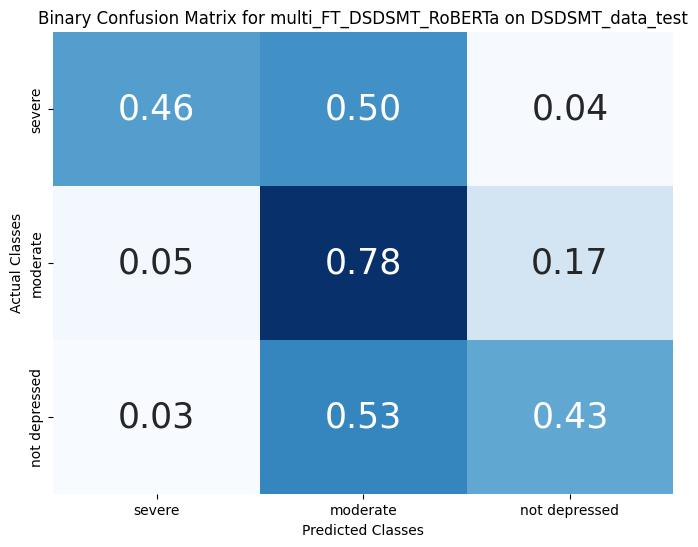

In [ ]:
view_and_save_metrics(data, predictions, title, path)

<Figure size 640x480 with 0 Axes>